$$
\begin{split}
D_{kl}(P\|Q)&=?\\
P(x)&=\mathcal N(\mu_1,\sigma_1)+\mathcal N(\mu_2, \sigma_2)\\
Q(x)&=\mathcal N(\mu_q=?, \sigma_q=?)
\end{split}
$$

In [103]:
import torch
import torch.nn.functional as F
from matplotlib import animation
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 120

## $P(x)$

In [111]:
mu1, sigma1 = -5, 1
mu2, sigma2 = 10, 1

In [112]:
gaussian1 = torch.distributions.Normal(mu1, sigma1)
gaussian2 = torch.distributions.Normal(mu2, sigma2)

Text(0.5, 1.0, '$\\mu_2$=10,$\\sigma_2$=1')

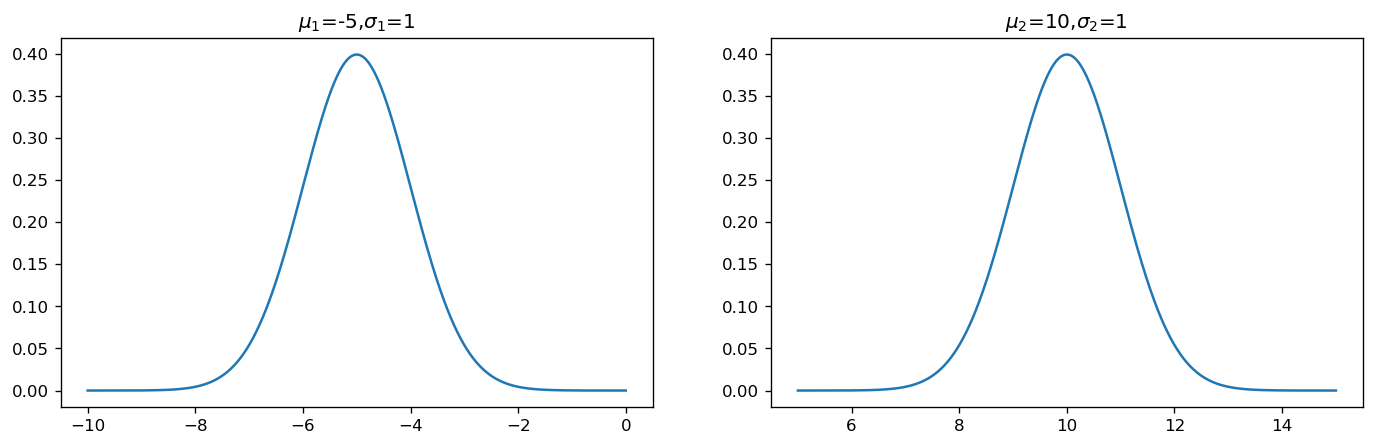

In [113]:
plt.figure(figsize=(14, 4))
x = torch.linspace(mu1-5*sigma1, mu1+5*sigma1, 1000)
plt.subplot(1, 2, 1)
plt.plot(x.numpy(), gaussian1.log_prob(x).exp().numpy())
plt.title(f'$\mu_1$={mu1},$\sigma_1$={sigma1}')

x = torch.linspace(mu2-5*sigma2, mu2+5*sigma2, 1000)
plt.subplot(1, 2, 2)
plt.plot(x.numpy(), gaussian2.log_prob(x).exp().numpy())
plt.title(f'$\mu_2$={mu2},$\sigma_2$={sigma2}')

$$
\exp^{\log x}=x
$$

Text(0.5, 1.0, '$P(X)$')

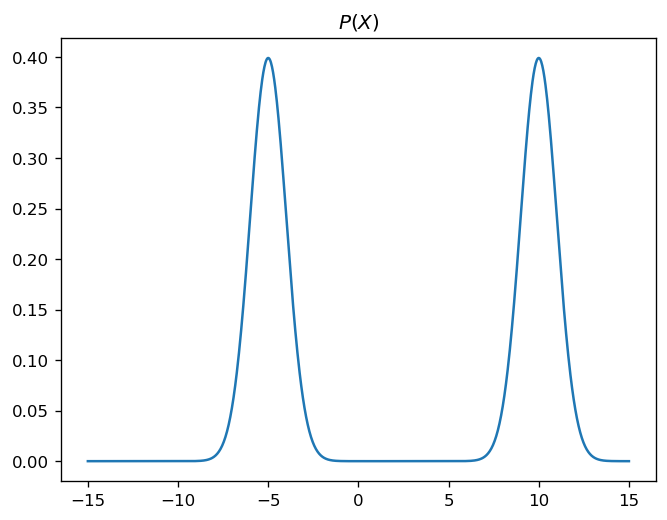

In [114]:
x = torch.linspace(-mu1-mu2-5*sigma1-5*sigma2, mu1+mu2+5*sigma1+5*sigma2, 1000)
px = gaussian1.log_prob(x).exp() + gaussian2.log_prob(x).exp()
plt.plot(x.numpy(), px.numpy())
plt.title(f'$P(X)$')

## Q(x)

In [115]:
mu = torch.tensor([0.0])
sigma = torch.tensor([1.0])

Text(0.5, 1.0, '$Q(X)$')

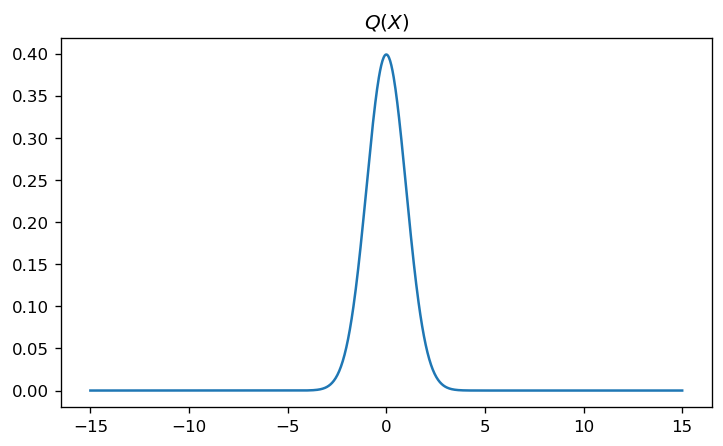

In [116]:
plt.figure(figsize=(7, 4))
x = torch.linspace(-mu1-mu2-5*sigma1-5*sigma2,mu1+mu2+5*sigma1+5*sigma2,1000)
Q = torch.distributions.Normal(mu, sigma) # this should approximate P, eventually :-)
qx = Q.log_prob(x).exp()
plt.plot(x.numpy(),qx.detach().numpy())
plt.title('$Q(X)$')

## kl-div

In [117]:
x = torch.linspace(-mu1-mu2-5*sigma1-5*sigma2,
                   mu1+mu2+5*sigma1+5*sigma2,
                   1000)
px = gaussian1.log_prob(x).exp() + gaussian2.log_prob(x).exp()

`F.kl_div`:
- input: Tensor of arbitrary shape in log-probabilities. : q(x)
- target: Tensor of the same shape as input. : p(x)
    - log_target: default `False`

In [118]:
qx = Q.log_prob(x).exp()
F.kl_div(qx.log(), px)

/home/whaow/anaconda3/lib/python3.10/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


tensor(inf)

In [119]:
qx = Q.log_prob(x)
F.kl_div(qx, px)

tensor(2.0812)

## kl-div as the loss

In [120]:
x = torch.linspace(-mu1-mu2-5*sigma1-5*sigma2,
                   mu1+mu2+5*sigma1+5*sigma2,
                   1000)
px = gaussian1.log_prob(x).exp() + gaussian2.log_prob(x).exp()

In [142]:
def optimize_loss(px, muq, sigmaq):
    
    mu = torch.tensor([muq], requires_grad=True)
    sigma = torch.tensor([sigmaq], requires_grad=True)
    
    opt = torch.optim.Adam([mu, sigma])
    
    all_mu = []
    all_sigma = []
    loss_val = []
    all_qx = []
    
    for i in range(10000):
        
        Q = torch.distributions.Normal(mu, sigma)
        qx = Q.log_prob(x)
        
        loss = F.kl_div(qx, px)
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        loss_val.append(loss.detach().numpy())
        all_mu.append(mu.data.numpy()[0])
        all_qx.append(qx.exp().detach().numpy())
        
        if i % 1000 == 0:
            print(i, loss_val[-1])
            
    plt.subplot(1, 2, 1)
    plt.plot(loss_val)
    plt.title('loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(all_mu)
    plt.title('$\mu$')
    return mu.data.numpy()[0], sigma.data.numpy()[0], all_qx

/home/whaow/anaconda3/lib/python3.10/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


0 2.081249
1000 0.73041356
2000 0.4642204
3000 0.34432057
4000 0.27543005
5000 0.23109896
6000 0.20085067
7000 0.1796072
8000 0.16454785
9000 0.15392812


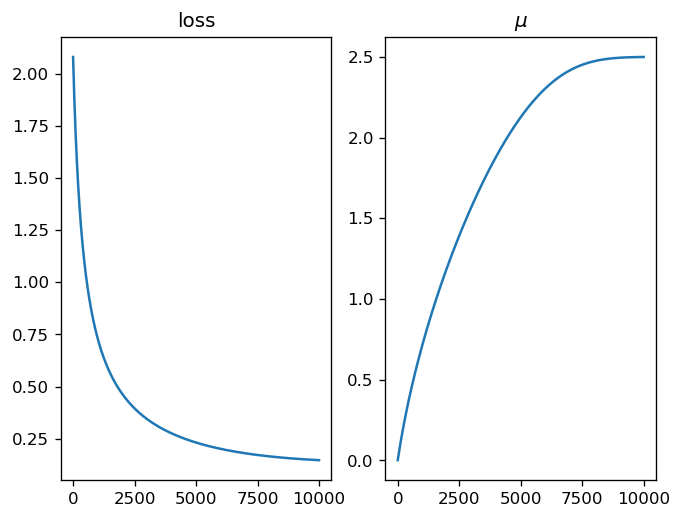

In [143]:
mu, sigma, all_qx = optimize_loss(px, 0., 1.)

In [123]:
len(all_qx)

10000

In [125]:
mu

2.4993849

## visualization

MovieWriter imagemagick unavailable; using Pillow instead.


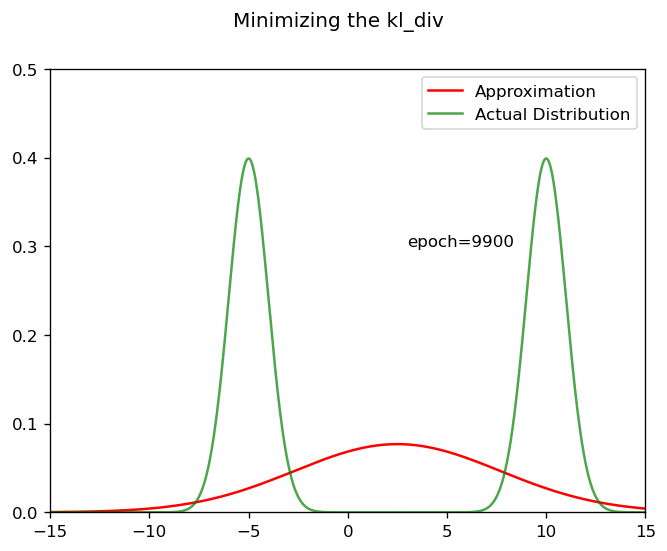

In [144]:
fig = plt.figure() 
ax = plt.axes(xlim=(x.min(),x.max()), ylim=(0,0.5)) 
text = ax.text(3,0.3,0)
line1, = ax.plot([], [], color = "r")
line2, = ax.plot([], [], color = "g",alpha=0.7)


def animate(i):    
    if i<75:
        line1.set_data(x.numpy(),all_qx[i*50])
        text.set_text(f'epoch={i*50}')
        line2.set_data(x.numpy(),px.numpy())
    else:
        line1.set_data(x.numpy(),all_qx[i*100])
        text.set_text(f'epoch={i*100}')
        line2.set_data(x.numpy(),px.numpy())

    return [line1,line2]

ani = animation.FuncAnimation(fig,animate,frames=100 ,interval=200, blit=True)
fig.suptitle(f'Minimizing the kl_div')
ax.legend(['Approximation','Actual Distribution'])
# save the animation as gif
ani.save('kl_div.gif', writer='imagemagick', fps=10) 

### mse loss

In [138]:
def optimize_loss(px, muq, sigmaq):
    
    mu = torch.tensor([muq], requires_grad=True)
    sigma = torch.tensor([sigmaq], requires_grad=True)
    
    opt = torch.optim.Adam([mu, sigma])
    
    all_mu = []
    all_sigma = []
    loss_val = []
    all_qx = []
    
    for i in range(10000):
        
        Q = torch.distributions.Normal(mu, sigma)
#         qx = Q.log_prob(x)
#         loss = F.kl_div(qx, px)
        qx = Q.log_prob(x).exp()
        loss = F.mse_loss(qx, px)
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        loss_val.append(loss.detach().numpy())
        all_mu.append(mu.data.numpy()[0])
        
        all_qx.append(qx.detach().numpy())
        
        if i % 1000 == 0:
            print(i, loss_val[-1])
            
    plt.subplot(1, 2, 1)
    plt.plot(loss_val)
    plt.title('loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(all_mu)
    plt.title('$\mu$')
    return mu.data.numpy()[0], sigma.data.numpy()[0], all_qx

0 0.028145004
1000 0.020257149
2000 0.015502928
3000 0.013607615
4000 0.010931816
5000 0.009393812
6000 0.009393757
7000 0.009393757
8000 0.009393757
9000 0.009393757


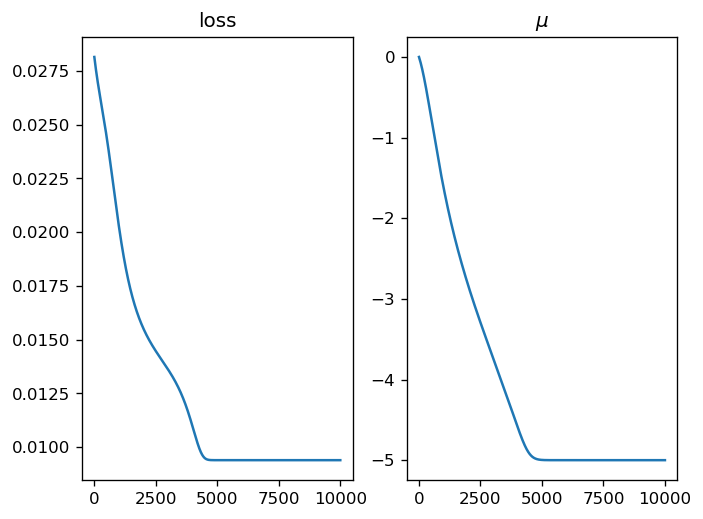

In [139]:
mu, sigma, all_qx = optimize_loss(px, 0., 1.)

MovieWriter imagemagick unavailable; using Pillow instead.


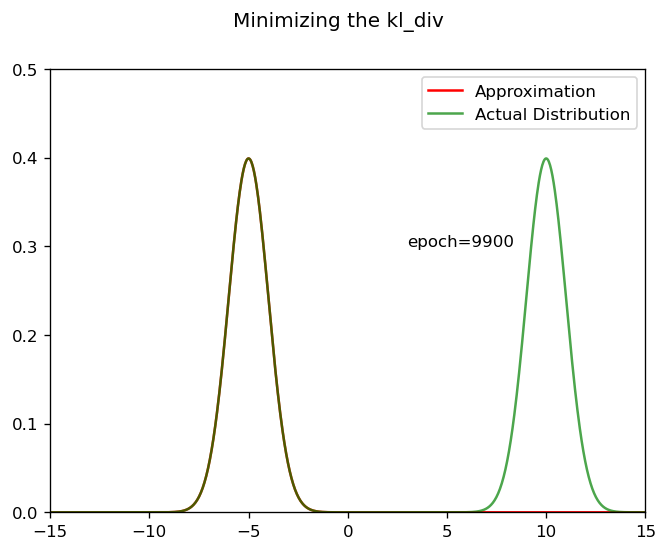

In [140]:
fig = plt.figure() 
ax = plt.axes(xlim=(x.min(),x.max()), ylim=(0,0.5)) 
text = ax.text(3,0.3,0)
line1, = ax.plot([], [], color = "r")
line2, = ax.plot([], [], color = "g",alpha=0.7)


def animate(i):    
    if i<75:
        line1.set_data(x.numpy(),all_qx[i*50])
        text.set_text(f'epoch={i*50}')
        line2.set_data(x.numpy(),px.numpy())
    else:
        line1.set_data(x.numpy(),all_qx[i*100])
        text.set_text(f'epoch={i*100}')
        line2.set_data(x.numpy(),px.numpy())

    return [line1,line2]

ani = animation.FuncAnimation(fig,animate,frames=100 ,interval=200, blit=True)
fig.suptitle(f'Minimizing the kl_div')
ax.legend(['Approximation','Actual Distribution'])
# save the animation as gif
ani.save('mse.gif', writer='imagemagick', fps=10) 